## Text generation using LSTM
Text generation is one of the language modelling problems. A LSTM (Long Short Term Memory) model has a state-of-the architecture for modeling sequence to sequence problems especially, regarding the text generation, translation and prediction.
We will be using n-gram tokenization to train the LSTM to generate news headlines from the news headlines dataset.


## Import the libraries

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Research/NLP/newyork_headline.zip"

Archive:  /content/drive/My Drive/Research/NLP/newyork_headline.zip
   creating: newyork_headline/
  inflating: newyork_headline/ArticlesFeb2017.csv  
  inflating: newyork_headline/ArticlesFeb2018.csv  
  inflating: newyork_headline/ArticlesJan2017.csv  
  inflating: newyork_headline/ArticlesJan2018.csv  
  inflating: newyork_headline/CommentsFeb2017.csv  
  inflating: newyork_headline/CommentsFeb2018.csv  
  inflating: newyork_headline/CommentsJan2017.csv  
  inflating: newyork_headline/CommentsJan2018.csv  


In [ ]:
!pwd

/content


### Load the dataset
It has 821 headlines from news articles in the last 15 years.
We load the csv files with Articles in their names and add the headlines to all_headlines array.

In [ ]:
curr_dir = "/content/newyork_headline/"
all_headlines = []
for filename in os.listdir(curr_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

821

In [ ]:
all_headlines[:10]

['Rhythm of the Streets: ‘We’re Warrior Women, and Yes, We Can Play’',
 'As Deficit Grows, Congress Keeps Spending',
 'Lesson in Select Bus Service',
 'Here’s the Real State of the Union',
 'Good Riddance to Chief Wahoo',
 'In South Africa, Facing ‘Day Zero’ With No Water',
 'How Trump’s Critics Should Respond',
 'A Republican Stalwart Sets Out on a Quest to Unseat Cuomo as Governor',
 '‘Beirut’ Trailer Was Supposed to Thrill. It Didn’t.',
 'Worker Who Sent Missile Alert Had Confused Drills for the Real Thing Before']

### Dataset preparation
#### Data Cleansing
As a part of data cleaning, we remove all the punctuation and convert all letters to lower case.


In [ ]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['rhythm of the streets were warrior women and yes we can play',
 'as deficit grows congress keeps spending',
 'lesson in select bus service',
 'heres the real state of the union',
 'good riddance to chief wahoo',
 'in south africa facing day zero with no water',
 'how trumps critics should respond',
 'a republican stalwart sets out on a quest to unseat cuomo as governor',
 'beirut trailer was supposed to thrill it didnt',
 'worker who sent missile alert had confused drills for the real thing before']

#### Generating Sequence of N-gram Tokens
Language models need input as tokens. n-gram is a technique used to group the text into meaningful chunks so that they can be used for training.
Tokenization is the process of splitting sentences into words (tokens). We used a Tokenizer provided by Keras to convert words into tokens and then build the n-grams from the corpus (all words available in the data). It assigns numeric values to the words in corpus and converts each headline into a sequence of numbers and also creates sub sequences with incremental lengths.

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[753, 4],
 [753, 4, 1],
 [753, 4, 1, 228],
 [753, 4, 1, 228, 161],
 [753, 4, 1, 228, 161, 754],
 [753, 4, 1, 228, 161, 754, 84],
 [753, 4, 1, 228, 161, 754, 84, 7],
 [753, 4, 1, 228, 161, 754, 84, 7, 162],
 [753, 4, 1, 228, 161, 754, 84, 7, 162, 38],
 [753, 4, 1, 228, 161, 754, 84, 7, 162, 38, 48]]

#### Padding the Sequences and obtain Variables
To train the model, the input needs to have a consistent shape, which can be obtained by adding zeroes to the inputs for the missing values. Padding is a process which helps us to achieve uniform length for the input.
The last word will be used as the label.
Remaining words will be used as the features.

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

### LSTMs for Text Generation
LSTM - The Long Short Term Memory network is trained on the padded sequences to generate text based on the input.

Embedding Layer is used to get more meaningful and better trained word representations.

Dropout Layer makes the model more regularized and prevents overfitting.

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 10)            25120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2512)              253712    
Total params: 323,232
Trainable params: 323,232
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(predictors, label, epochs=100, verbose=5)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### Generating the text
We need to pre-process the input the same way we did the train data and use it to pass to the model to generate new text.
seed_text: We need to pass a seed text: a starting part of the prediction.
next_words: number of words expected to predict after seed text
model: the LSTM model trained
max_sequence_len: The maximum length of the sequences.

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
generate_text("America", 10, model, max_sequence_len)

'America Trek Discovery Season 1 Episode 13 Another Death Another Twist'

In [ ]:
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("president trump", 4, model, max_sequence_len))
print (generate_text("donald trump", 4, model, max_sequence_len))
print (generate_text("india and china", 4, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 5, model, max_sequence_len))

United States Awards Stages Into Soapboxes For
President Trump Obstruct Justice Get A
Donald Trump Obstruct Justice Get Springer
India And China Help Toronto Make The
New York Curtails Reach Of Bank
Science And Technology Placed On The Sea Of


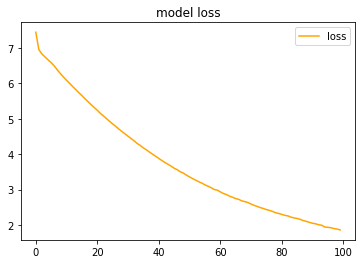

In [ ]:
import matplotlib.pyplot as plt
# graph
plt.plot(history.history['loss'], color="orange")
# plt.plot(history.history['accuracy'], color="green")
plt.title('model loss')
plt.legend(['loss'], loc='upper right')
plt.show()